**1-Importing the libraries**

In [2]:
import torch
import numpy as np
import pandas as pd
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**2-defining the training data path and testing data path**

In [3]:
train_path = "/content/drive/My Drive/Dataset/Train"
test_path = "/content/drive/My Drive/Dataset/Test"

**3-Checking gpu availability**

In [4]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


**4-transforming and normalising the data**

In [5]:
num_workers = 0

batch_size = 20
valid_size = 0.2

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_image_path = "/content/drive/My Drive/Dataset/Train"
test_image_path = "/content/drive/My Drive/Dataset/Test"

train_dataset = datasets.ImageFolder(train_image_path, transform=transform)

test_dataset = datasets.ImageFolder(test_image_path , transform = transform)

**5-Defining the test sampler**

shuffling the indices of the test data and loading it.

In [7]:
num_test = len(test_dataset)
indices_test = list(range(num_test))
np.random.shuffle(indices_test)
test_idx = indices_test
test_sampler = SubsetRandomSampler(indices_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                            sampler=test_sampler , num_workers=num_workers)

**6-Loading the training and validation data similarly**

splitting training data into validation and training data.

In [9]:
num_train = len(train_dataset)
#print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

classes = [0,1]

**7-Visualising the Dataset**

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

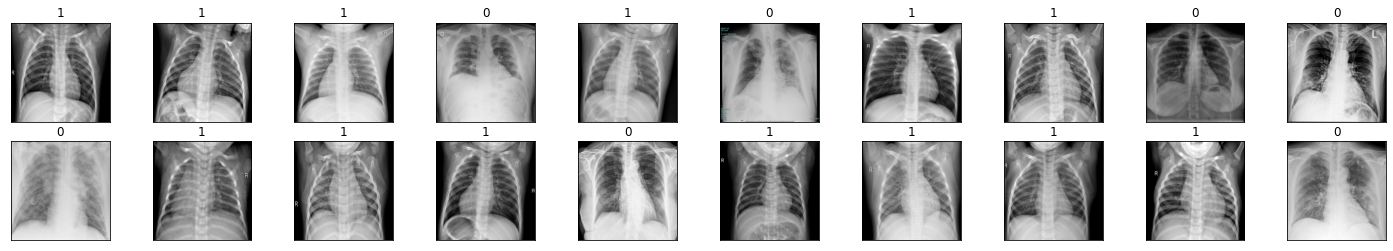

In [11]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
   # print(labels[idx])
    ax.set_title(classes[labels[idx]])

**8-Defining the model architecture for CNN**

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding =1)
        self.conv2 = nn.Conv2d(32,64,3,padding =1)
        self.pool = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(p=0.25,inplace = True)
        self.drop2 = nn.Dropout(p=0.5,inplace = True)
        self.conv3 = nn.Conv2d(64,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        self.fc1 = nn.Linear(28*28*128,64)
        self.fc2 = nn.Linear(64,2)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.drop1(x)
        x = x.view(-1,28*28*128)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.softmax(self.fc2(x))
        return x

# create a complete CNN
model = Net()
if train_on_gpu:
  model.cuda()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=True)
  (drop2): Dropout(p=0.5, inplace=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): LogSoftmax()
)


**9-Selecting the Loss criterion and optimizer function**

In [34]:
criterion  = nn.CrossEntropyLoss(weight=None,size_average=True)
optimizer  = optim.Adam(model.parameters() , lr=0.003)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


**10- Training the data**

Training the data and calculating training and validation loss for each epoch and loading the model with minimum validation loss.

In [35]:
total_epochs = 50
min_loss = 1e18

for epochs in range(0,total_epochs):
    torch.cuda.empty_cache()
    t_loss= 0.0
    v_loss= 0.0
    model.train()

    for data,target in train_loader:
        if train_on_gpu:
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()*data.size(0)

    model.eval()
    for data,target in valid_loader:
        if train_on_gpu:
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss = criterion(output,target)
        v_loss += loss.item()*data.size(0)
    
    t_loss/= len(train_loader.sampler)
    v_loss/= len(valid_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epochs, t_loss, v_loss))
    
    if v_loss <= min_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        min_loss,
        v_loss))
        torch.save(model.state_dict(), 'cur_model.pt')
        min_loss = v_loss
        

Epoch: 0 	Training Loss: 0.447452 	Validation Loss: 0.127160
Validation loss decreased (1000000000000000000.000000 --> 0.127160).  Saving model ...
Epoch: 1 	Training Loss: 0.192142 	Validation Loss: 0.214671
Epoch: 2 	Training Loss: 0.194195 	Validation Loss: 0.111111
Validation loss decreased (0.127160 --> 0.111111).  Saving model ...
Epoch: 3 	Training Loss: 0.140079 	Validation Loss: 0.129517
Epoch: 4 	Training Loss: 0.111478 	Validation Loss: 0.185898
Epoch: 5 	Training Loss: 0.118418 	Validation Loss: 0.144858
Epoch: 6 	Training Loss: 0.090068 	Validation Loss: 0.194231
Epoch: 7 	Training Loss: 0.061762 	Validation Loss: 0.169252
Epoch: 8 	Training Loss: 0.056544 	Validation Loss: 0.281772
Epoch: 9 	Training Loss: 0.050133 	Validation Loss: 0.226669
Epoch: 10 	Training Loss: 0.056262 	Validation Loss: 0.270278
Epoch: 11 	Training Loss: 0.074115 	Validation Loss: 0.231385
Epoch: 12 	Training Loss: 0.021290 	Validation Loss: 0.397707
Epoch: 13 	Training Loss: 0.020139 	Validation L

**11-Loading the saved model with minimum validation loss**

In [28]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('cur_model.pt'))
if train_on_gpu:
    model = model.cuda()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=True)
  (drop2): Dropout(p=0.5, inplace=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

**12-Testing the model**

In [36]:
test_loss = 0.0
class_correct = list(0.0 for i in range(2) )
class_total = list(0.0 for i in range(2))

model.eval()

for data,target in test_loader:
    if train_on_gpu:
        data = data.cuda()
        target = target.cuda()
    
    output = model(data)
    loss = criterion(output,target)
    test_loss+= loss.item()*data.size(0)
    
    _ , pred = torch.max(output,dim=1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.953310

Test Accuracy of     0: 98% (50/51)
Test Accuracy of     1: 98% (50/51)

Test Accuracy (Overall): 98% (100/102)
